In [48]:
import torch
from torch import nn

from torchvision import datasets
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

## 0. Load datset

In [49]:
# Load dataset

train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [50]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

## 1. Train simple model

In [51]:
# Select the best device to use
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: mps


In [52]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [53]:
def train_model(model, optimizer, loss_fn):
    torch.manual_seed(42)
    epochs = 1

    for epoch in range(epochs):
        print(f"[EPOCH {epoch+1}/{epochs}] ", end="")
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)
            model.train()

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            train_loss += loss

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

        train_loss /= len(train_dataloader)

        test_loss, test_acc = 0, 0
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                test_pred = model(X)

                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(y, test_pred.argmax (dim=1))

            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader)

        print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

In [54]:
# Build the model
inputs = 784
hidden1 = 300
hidden2 = 100
outputs = 10

assert(outputs == len(train.classes))

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(inputs, outputs),
    nn.Sigmoid(),
    #nn.Linear(hidden1, outputs),
    #nn.Sigmoid(),
    #nn.Linear(hidden2, outputs)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [55]:
train_model(model, optimizer, loss_fn)

[EPOCH 1/1] Train loss: 1.73621 | Test loss: 1.64929, Test acc: 87.61%


## 2. Backward Activation

In [56]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)

In [57]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_inv(x):
    return np.log(x/(1-x))

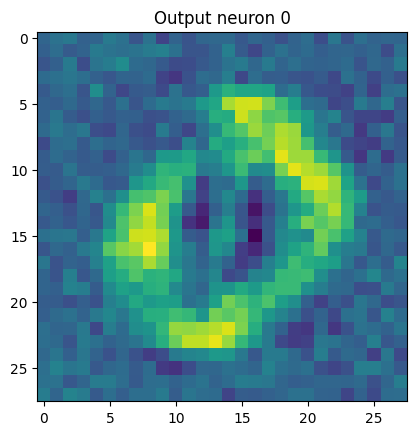

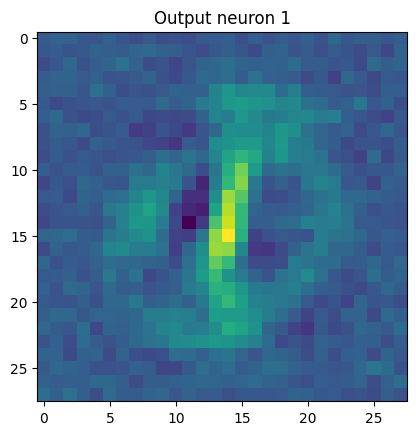

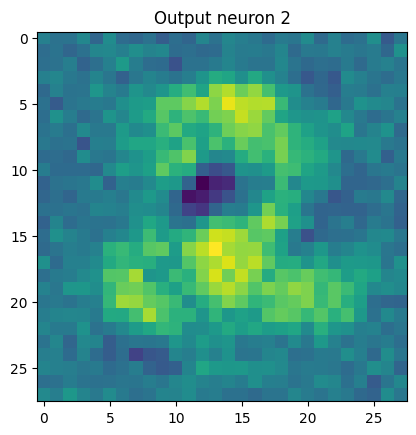

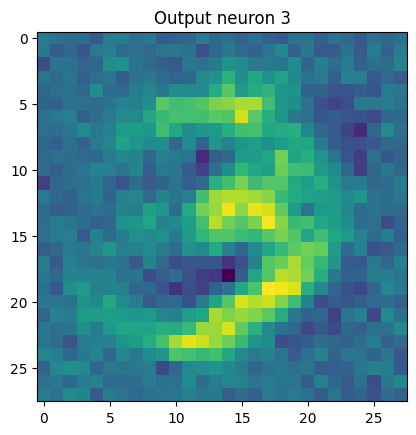

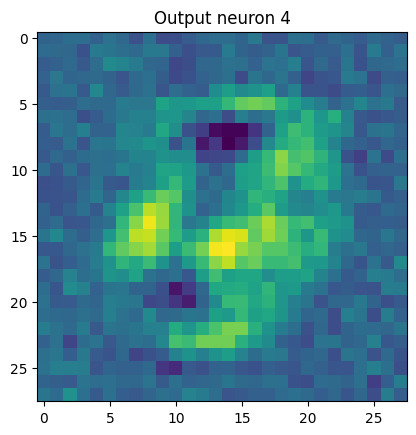

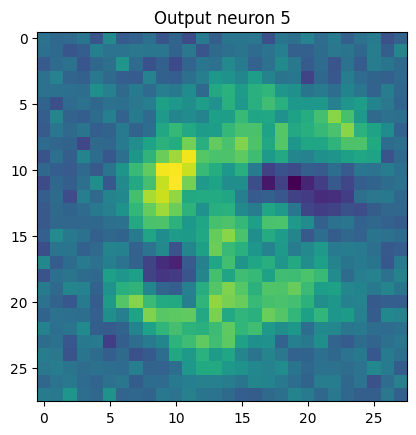

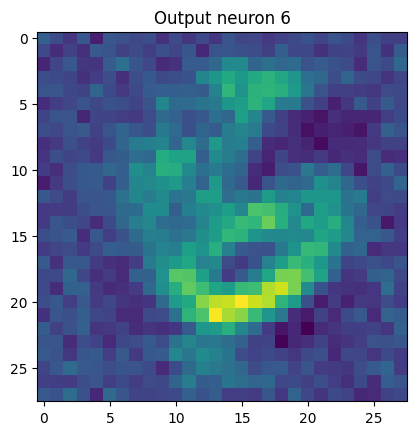

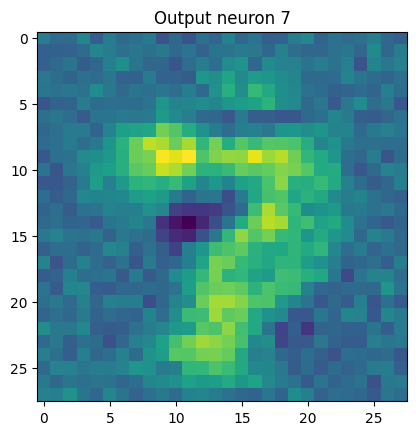

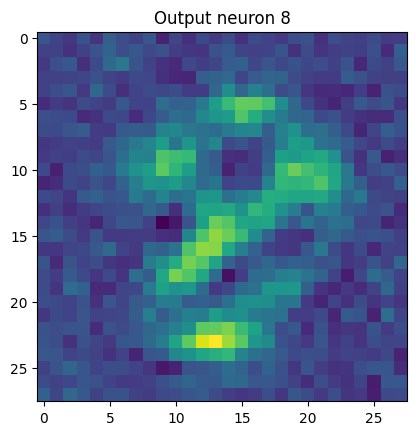

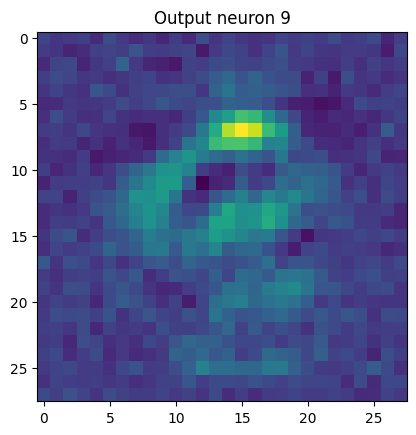

In [58]:
#output = model.forward(train[1][0].to(device)).to('cpu').detach().numpy()
epsilon = 2e-1
for digit in range(10):

    output = epsilon*np.ones(10)
    output[digit] = 1-epsilon

    A_back = [None] * L + [output]

    for l in range(0, L)[::-1]:
        A_back[l] = (sigmoid_inv(A_back[l+1])-B[l]) @ np.linalg.pinv(W[l])

    plt.imshow(A_back[0].reshape((28, 28)))
    plt.title(f"Output neuron {digit}")
    plt.show()

In [59]:
model.forward(train[0][0].to(device)).to('cpu').detach()

tensor([[2.8074e-02, 2.5729e-03, 1.9704e-02, 8.0221e-01, 1.3831e-04, 7.0740e-01,
         1.8406e-02, 7.4809e-02, 2.6923e-02, 8.3288e-03]])

In [60]:
# Forward pass
A = [A_back[0]] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [61]:
A[L]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.38629436])